<span style="color:Red">MinMax diversity</span> is a particular case of <span style="color:Red">Kennard-Stone algorithm</span>, the purpose of these algorithms is to split the dataset into two parts based on user-selected factors, e.g. molecular descriptors. The main purpose of this procedure in cheminformatics is to get the test (or validation, or optimization set) for Machine-learning, such as QSAR modelling.

The gist of the algorithm is an iterative selection of new training set candidates from the remaining dataset, so that every new candidate had the highest out of lowest dissimilarities between the candidates and all of the training set compounds. The procedure is repeated until the desired split ratio (e. g. 75% training, 25% test is achieved). The goal of the splitting is to create the training set that comprises the full diversity of the overall dataset, whereas test set does not have compounds that are too different from the training set. <u>It is important to mention that the results of the splitting are quite dependent on similarity metric and descriptor space.<u>

In [45]:
import rdkit as rd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import copy
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem import GraphDescriptors
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
import numpy as np
import pandas as pd
import pickle

In [46]:
from rdkit.Chem import rdFMCS
cox2_sdf = r'assets/COX2_inhibitors_final.sdf'
df = PandasTools.LoadSDF(cox2_sdf, molColName='Mol')
df["Inhibition, %"] = df["Inhibition, %"].astype(int)

In [47]:
descr_df = np. full((df.shape[0], 4), 0, dtype="float64")
for i in range(0, len(df.index)):
    descr_bundle = []
    mol = df[ 'Mol'][i]
    descr_bundle.append(rdMolDescriptors.CalcNumAromaticRings(mol))
    descr_bundle.append(Descriptors.NumValenceElectrons(mol))
    descr_bundle.append(round(GraphDescriptors.BalabanJ(mol), 2))
    descr_bundle.append(round(rdMolDescriptors.CalcExactMolWt(mol), 1))
    descr_df[i,0:len(descr_bundle)] = descr_bundle
descr_df = pd.DataFrame(descr_df, index = df[ 'CHEMBLID'])
### naming the descr df
descr_names = ['NumAromaticRings', 'NumValenceElectrons','BalabanJ', 'MW']
descr_df.columns = descr_names
descr_df.head()

,NumAromaticRings,NumValenceElectrons,BalabanJ,MW
CHEMBLID,,,,
CHEMBL366429,2.0,126.0,2.02,365.1
CHEMBL176216,2.0,146.0,1.79,458.0
CHEMBL174680,3.0,136.0,1.86,380.1
CHEMBL176357,3.0,138.0,1.83,421.0
CHEMBL369840,2.0,142.0,2.13,465.9


In [48]:
### structural keys
finger_df = np. full((df.shape[0], 167), 0, dtype="float64" )
for i in range(0, len(df. index)) :
    finger_df[i, :] = np.array(rdMolDescriptors.GetMACCSKeysFingerprint(df['Mol'][i]))
finger_df = pd. DataFrame(finger_df, index = df[ 'CHEMBLID' ])
del (finger_df[0]) # removing Ithe empty coLumn
MACCSkeys_names = list(MACCSkeys. smartsPatts.values())
finger_df.columns = MACCSkeys_names

In [49]:
# capstone descr
capstone_desc_path = r"/Users/marcusc/Documents/Courses/neovarsity_chemoinformatics_2024/assets/chap8_output_halogen.csv" 
capstone_desc = pd.read_csv(capstone_desc_path, index_col='CHEMBLID')[['HalogenBondDonor']]
capstone_desc.head()

,HalogenBondDonor
CHEMBLID,
CHEMBL366429,False
CHEMBL176216,True
CHEMBL174680,False
CHEMBL176357,True
CHEMBL369840,True


In [50]:
### merge descr spaces
descr_df_full = pd. concat((capstone_desc, descr_df, finger_df), axis = 1)
descr_df_full.head()

,HalogenBondDonor,NumAromaticRings,NumValenceElectrons,BalabanJ,MW,"(?, 0)","([#104], 0)","([#32,#33,#34,#50,#51,#52,#82,#83,#84], 0)","([Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr], 0)","([Sc,Ti,Y,Zr,Hf], 0)",...,"([#6]-[#8], 0)","([#6]-[#7], 0)","([#8], 1)","([C;H3,H4], 0)","([#7], 0)","(a, 0)","(*1~*~*~*~*~*~1, 0)","([#8], 0)","([R], 0)","(?, 0)"
CHEMBLID,,,,,,,,,,,,,,,,,,,,,
CHEMBL366429,False,2.0,126.0,2.02,365.1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL176216,True,2.0,146.0,1.79,458.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL174680,False,3.0,136.0,1.86,380.1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL176357,True,3.0,138.0,1.83,421.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL369840,True,2.0,142.0,2.13,465.9,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [51]:
### descr space output
descr_df_full.to_csv(r"/Users/marcusc/Documents/Courses/neovarsity_chemoinformatics_2024/assets/chap10_full_desc.csv")

### Kennard-Stone algorithm description
1. first two starting points are picked based on biggest Euclidean distance in the dataset
2. next point is added based on highest out of lowest Euclidean distance between the candidates and all of the training set compounds.
3. repeat step 2 until the desired training-to-test ratio is achieved

### source: R. W. Kennard & L. A. Stone (1969) Computer Aided Design of Experiments, Technometrics, 11:1, 137-148. doi:10.1080/00401706.1969.10490666

In [52]:
print(*descr_df_full.columns)

HalogenBondDonor NumAromaticRings NumValenceElectrons BalabanJ MW ('?', 0) ('[#104]', 0) ('[#32,#33,#34,#50,#51,#52,#82,#83,#84]', 0) ('[Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr]', 0) ('[Sc,Ti,Y,Zr,Hf]', 0) ('[La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu]', 0) ('[V,Cr,Mn,Nb,Mo,Tc,Ta,W,Re]', 0) ('[!#6;!#1]1~*~*~*~1', 0) ('[Fe,Co,Ni,Ru,Rh,Pd,Os,Ir,Pt]', 0) ('[Be,Mg,Ca,Sr,Ba,Ra]', 0) ('*1~*~*~*~1', 0) ('[Cu,Zn,Ag,Cd,Au,Hg]', 0) ('[#8]~[#7](~[#6])~[#6]', 0) ('[#16]-[#16]', 0) ('[#8]~[#6](~[#8])~[#8]', 0) ('[!#6;!#1]1~*~*~1', 0) ('[#6]#[#6]', 0) ('[#5,#13,#31,#49,#81]', 0) ('*1~*~*~*~*~*~*~1', 0) ('[#14]', 0) ('[#6]=[#6](~[!#6;!#1])~[!#6;!#1]', 0) ('*1~*~*~1', 0) ('[#7]~[#6](~[#8])~[#8]', 0) ('[#7]-[#8]', 0) ('[#7]~[#6](~[#7])~[#7]', 0) ('[#6]=;@[#6](@*)@*', 0) ('[I]', 0) ('[!#6;!#1]~[CH2]~[!#6;!#1]', 0) ('[#15]', 0) ('[#6]~[!#6;!#1](~[#6])(~[#6])~*', 0) ('[!#6;!#1]~[F,Cl,Br,I]', 0) ('[#6]~[#16]~[#7]', 0) ('[#7]~[#16]', 0) ('[CH2]=*', 0) ('[Li,Na,K,Rb,Cs,Fr]', 0) ('[#16R]', 0) ('[#7]~[#6

In [53]:
# from kennard
descr_df_full.head()

,HalogenBondDonor,NumAromaticRings,NumValenceElectrons,BalabanJ,MW,"(?, 0)","([#104], 0)","([#32,#33,#34,#50,#51,#52,#82,#83,#84], 0)","([Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr], 0)","([Sc,Ti,Y,Zr,Hf], 0)",...,"([#6]-[#8], 0)","([#6]-[#7], 0)","([#8], 1)","([C;H3,H4], 0)","([#7], 0)","(a, 0)","(*1~*~*~*~*~*~1, 0)","([#8], 0)","([R], 0)","(?, 0)"
CHEMBLID,,,,,,,,,,,,,,,,,,,,,
CHEMBL366429,False,2.0,126.0,2.02,365.1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL176216,True,2.0,146.0,1.79,458.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL174680,False,3.0,136.0,1.86,380.1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL176357,True,3.0,138.0,1.83,421.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL369840,True,2.0,142.0,2.13,465.9,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


## Kennard stone algo

In [54]:
# install kennard_stone
# conda activate neovarsity
# conda install kennard-stone

In [55]:
print(df.columns) # id is integers
descr_df_full.head() # id is chemblid

Index(['SMILES', 'CHEMBLID', 'Inhibition, %', 'ID', 'Mol'], dtype='object')


,HalogenBondDonor,NumAromaticRings,NumValenceElectrons,BalabanJ,MW,"(?, 0)","([#104], 0)","([#32,#33,#34,#50,#51,#52,#82,#83,#84], 0)","([Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr], 0)","([Sc,Ti,Y,Zr,Hf], 0)",...,"([#6]-[#8], 0)","([#6]-[#7], 0)","([#8], 1)","([C;H3,H4], 0)","([#7], 0)","(a, 0)","(*1~*~*~*~*~*~1, 0)","([#8], 0)","([R], 0)","(?, 0)"
CHEMBLID,,,,,,,,,,,,,,,,,,,,,
CHEMBL366429,False,2.0,126.0,2.02,365.1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL176216,True,2.0,146.0,1.79,458.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL174680,False,3.0,136.0,1.86,380.1,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL176357,True,3.0,138.0,1.83,421.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CHEMBL369840,True,2.0,142.0,2.13,465.9,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [56]:
from kennard_stone import train_test_split

In [57]:
x_train, x_test, y_train, y_test = train_test_split(descr_df_full, df['Inhibition, %'], test_size=0.25) # descriptors, y_values

2025-04-21 21:42:50,137 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

2025-04-21 21:42:50,138 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.



In [58]:
print(len(df))

139


In [59]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

104
35
104
35


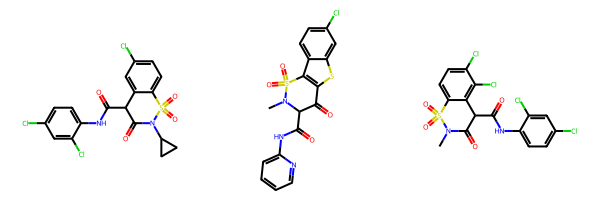

In [60]:
#:## visualize test set selection
ts_sel_vector = descr_df_full.index.isin(x_test.index)
# Draw.MolsToGridImage(df.loc[ts_sel_vector][ 'Mol'])
Draw.MolsToGridImage(df.loc[~ts_sel_vector][ 'Mol'][:3])

In [61]:
ts_set_index = descr_df_full.loc[ts_sel_vector].index
print(len(ts_set_index))
ts_set_index

35


Index(['CHEMBL366429', 'CHEMBL174680', 'CHEMBL367858', 'CHEMBL173890',
       'CHEMBL174494', 'CHEMBL173012', 'CHEMBL177412', 'CHEMBL175001',
       'CHEMBL424788', 'CHEMBL174930', 'CHEMBL176504', 'CHEMBL367118',
       'CHEMBL177082', 'CHEMBL173072', 'CHEMBL177433', 'CHEMBL369492',
       'CHEMBL174777', 'CHEMBL177915', 'CHEMBL369702', 'CHEMBL177580',
       'CHEMBL179715', 'CHEMBL368769', 'CHEMBL368916', 'CHEMBL177606',
       'CHEMBL175974', 'CHEMBL367864', 'CHEMBL369021', 'CHEMBL179105',
       'CHEMBL177313', 'CHEMBL177288', 'CHEMBL174888', 'CHEMBL177879',
       'CHEMBL368808', 'CHEMBL174990', 'CHEMBL177982'],
      dtype='object', name='CHEMBLID')

## Principles of minmax diversity

1. initialise subset with appropriately chosen seed compound and set x:=1
2. for each of N-x remaining compounds in *Dataset*, calculate its dissimilarity  with each of the x compounds in the subset and retain the smallest of these x dissimilarities for each compound in *Datset*
3. Select the molecule from *Dataset* with the largest value for the smallest dissimilarity calculated in step 2, and transfer it to subset

The **MinMax Diversity** method is a greedy algorithm designed to select a subset of compounds that maximizes diversity by ensuring each new addition is the least similar (most dissimilar) to the closest compound already in the subset. Here's a breakdown of the principles with an example:

---

### **Step-by-Step Explanation**

#### **1. Initialize Subset with a Seed Compound**
- **Goal**: Start with a seed compound (e.g., chosen for centrality, diversity, or randomly).
- **Example**: Suppose we have compounds **A, B, C, D, E** with pairwise dissimilarities (values between 0 and 1, where 1 = maximally dissimilar). Let’s choose **A** as the seed.  
  - **Subset**: `{A}`  
  - **x** (subset size): `1`

---

#### **2. Calculate Dissimilarities**
- For each remaining compound in the dataset, compute its dissimilarity to **every compound in the subset** and retain the **smallest dissimilarity** (i.e., the closest neighbor in the subset).  
- **Why the smallest dissimilarity?** It identifies how similar a compound is to the **most similar member** of the subset. We want to avoid compounds that are too similar to any subset member.

**Example**:  
- Dissimilarities from remaining compounds (B, C, D, E) to subset `{A}`:  
  - `A-B: 0.2`, `A-C: 0.5`, `A-D: 0.7`, `A-E: 0.3`  
- **Smallest dissimilarities** (closest neighbor in subset):  
  - `B: 0.2`, `C: 0.5`, `D: 0.7`, `E: 0.3`

---

#### **3. Select the Compound with the Largest Minimum Dissimilarity**
- Choose the compound with the **largest value** from the retained smallest dissimilarities. This ensures the new compound is **least similar** to its closest neighbor in the subset, maximizing diversity.  
- **Example**:  
  - Largest value: **D (0.7)**  
  - **Update subset**: `{A, D}`  
  - **x**: `2`

---

### **Repeat Steps 2–3 Until Subset Reaches Desired Size**

#### **Iteration 2**
- **Subset**: `{A, D}`  
- **Remaining compounds**: B, C, E  
- Calculate smallest dissimilarities for each compound:  
  - **B**: `min(A-B=0.2, D-B=0.6) = 0.2`  
  - **C**: `min(A-C=0.5, D-C=0.4) = 0.4`  
  - **E**: `min(A-E=0.3, D-E=0.5) = 0.3`  
- **Largest value**: **C (0.4)**  
- **Update subset**: `{A, D, C}`  

---

#### **Iteration 3**
- **Subset**: `{A, D, C}`  
- **Remaining compounds**: B, E  
- Calculate smallest dissimilarities:  
  - **B**: `min(A-B=0.2, D-B=0.6, C-B=0.3) = 0.2`  
  - **E**: `min(A-E=0.3, D-E=0.5, C-E=0.8) = 0.3`  
- **Largest value**: **E (0.3)**  
- **Update subset**: `{A, D, C, E}`  

---

#### **Final Subset**
- If the goal is 4 compounds: `{A, D, C, E}`.  
- **Diversity**: Each new compound is the least similar to its closest neighbor in the subset.

---

### **Key Takeaways**
1. **Seed Choice**: The initial compound affects subsequent selections. A central or diverse seed often works best.  
2. **Greedy Strategy**: At each step, the algorithm picks the compound that maximizes the minimum distance to the subset.  
3. **Analogy**: Similar to "farthest point sampling" in geometry, ensuring coverage of the chemical space.

---

### **Why This Works**
- Maximizes the minimal dissimilarity between the subset and remaining compounds.  
- Avoids redundancy by prioritizing compounds least similar to existing members.  
- Efficiently builds a diverse subset without exhaustive comparison of all possible combinations.

In [62]:
from rdkit.SimDivFilters import rdSimDivPickers
from rdkit import SimDivFilters
from rdkit import DataStructs

In [ ]:
# 
morgan_fingerprints = []
bit_morgan = [{}] # label fingerprints
i = 0
for mol in df['Mol']:
    bit_morgan.append({})
    morgan_fingerprints.append(
        rdMolDescriptors.GetMorganFingerprint
    )